# Analyse du fichier `Transportation and Logistics`

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath("../.."))
from utils.db_utils import connect_db

In [3]:
# Connexion à la base et chargement
engine = connect_db()
df = pd.read_sql("SELECT * FROM clean_transportation_and_Logistics", engine)

In [4]:
# Prétraitement
df["trip_start_date"] = pd.to_datetime(df["trip_start_date"], errors="coerce")
df["month"] = df["trip_start_date"].dt.to_period("M")
monthly_trips = df.groupby("month").size()
delay_counts = df["delay"].value_counts()
distance_data = df["transportation_distance_in_km"].dropna()
top_origins = df["origin_location"].value_counts().head(10)
top_destinations = df["destination_location"].value_counts().head(10)

# Volume par mois

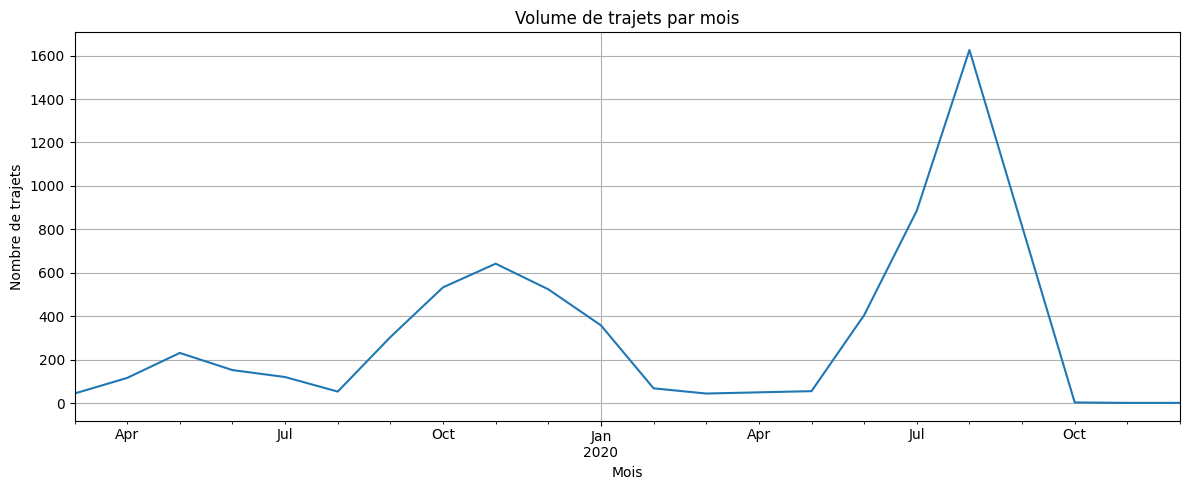

In [ ]:

plt.figure(figsize=(12, 5))
monthly_trips.plot()
plt.title("Volume de trajets par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre de trajets")
plt.grid(True)
plt.tight_layout()
plt.show()

# Distribution des distances

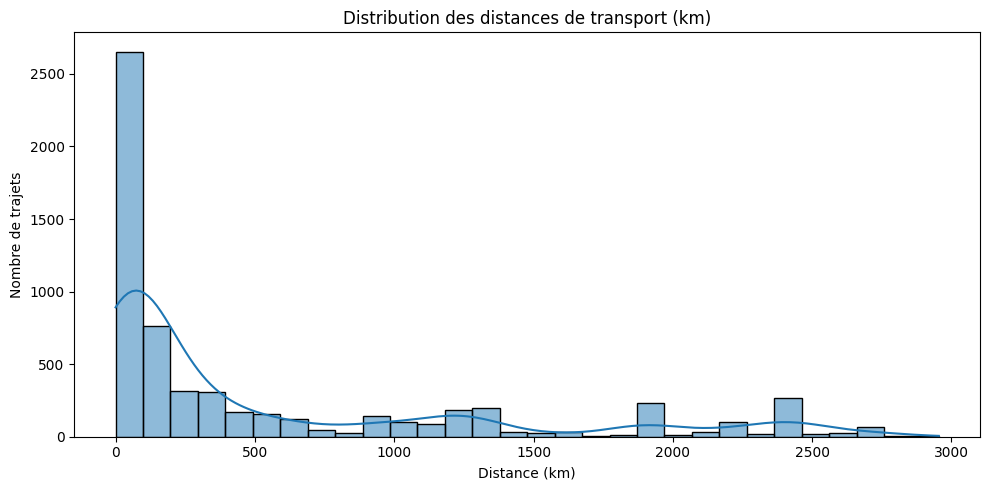

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(distance_data, bins=30, kde=True)
plt.title("Distribution des distances de transport (km)")
plt.xlabel("Distance (km)")
plt.ylabel("Nombre de trajets")
plt.tight_layout()
plt.show()

# Top origines et destinations

C:\Users\ahmed\AppData\Local\Temp\ipykernel_32624\3436514023.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


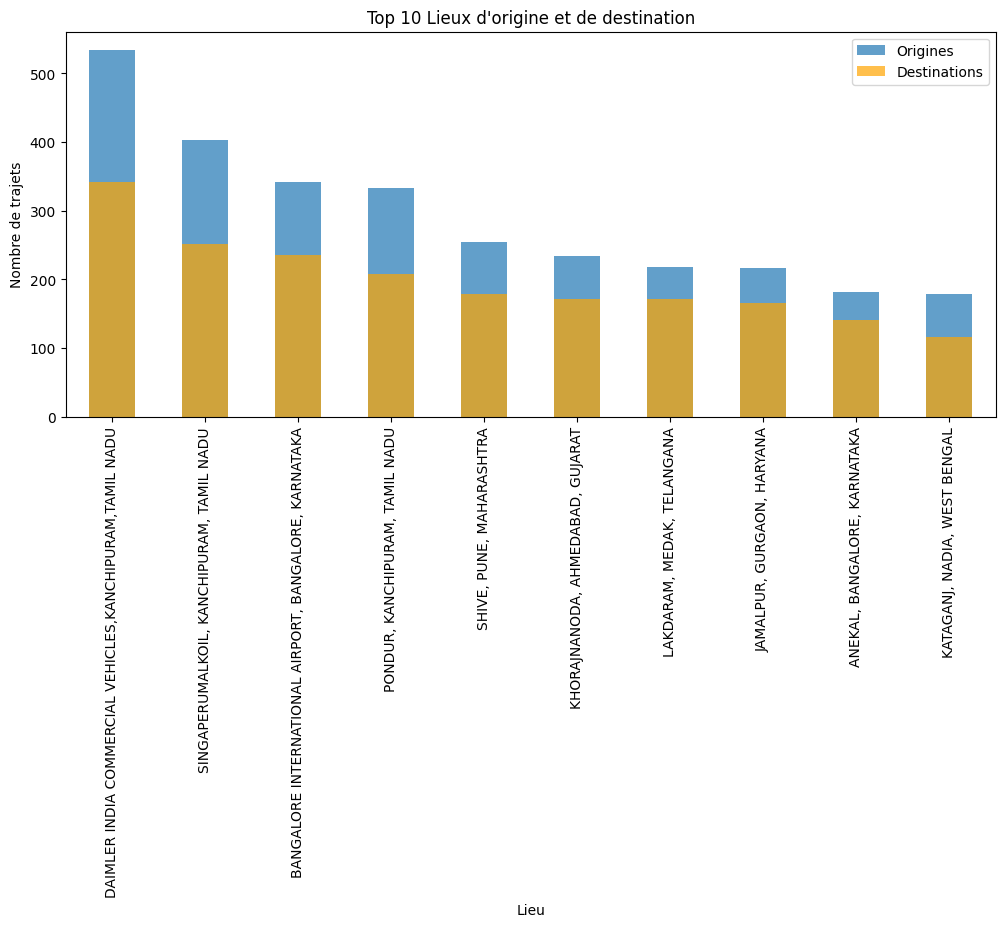

In [ ]:

plt.figure(figsize=(12, 5))
top_origins.plot(kind="bar", label="Origines", alpha=0.7)
top_destinations.plot(kind="bar", label="Destinations", alpha=0.7, color="orange")
plt.title("Top 10 Lieux d'origine et de destination")
plt.xlabel("Lieu")
plt.ylabel("Nombre de trajets")
plt.legend()
plt.tight_layout()
plt.show()

# Top 10 véhicules les plus utilisés

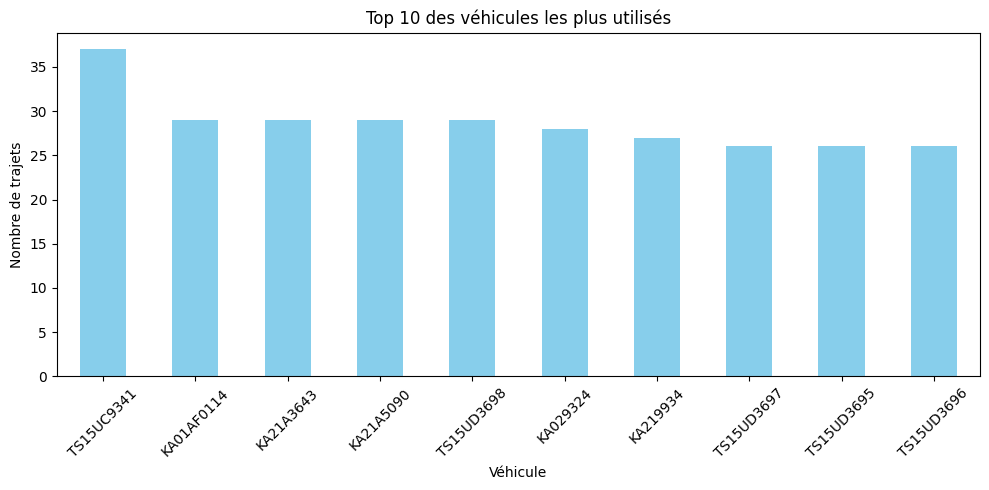

In [9]:
top_vehicles = df["vehicle_no"].value_counts().head(10)

plt.figure(figsize=(10, 5))
top_vehicles.plot(kind="bar", color="skyblue")
plt.title("Top 10 des véhicules les plus utilisés")
plt.xlabel("Véhicule")
plt.ylabel("Nombre de trajets")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Carte des coordonnées de suivi

In [15]:
# Séparer org_lat_lon en deux colonnes : org_latitude et org_longitude
if "org_lat_lon" in df.columns:
    df[["org_latitude", "org_longitude"]] = df["org_lat_lon"].str.split(",", expand=True)
    df["org_latitude"] = pd.to_numeric(df["org_latitude"], errors="coerce")
    df["org_longitude"] = pd.to_numeric(df["org_longitude"], errors="coerce")

# Séparer des_lat_lon en deux colonnes : des_latitude et des_longitude
if "des_lat_lon" in df.columns:
    df[["des_latitude", "des_longitude"]] = df["des_lat_lon"].str.split(",", expand=True)
    df["des_latitude"] = pd.to_numeric(df["des_latitude"], errors="coerce")
    df["des_longitude"] = pd.to_numeric(df["des_longitude"], errors="coerce")


In [17]:
import folium

# Carte centrée sur la moyenne
m = folium.Map(
    location=[df["org_latitude"].mean(), df["org_longitude"].mean()],
    zoom_start=6
)

# Ajouter les routes avec info interactives
for _, row in df.dropna(subset=["org_latitude", "org_longitude", "des_latitude", "des_longitude"]).iterrows():
    popup_text = f"""
    <b>Booking ID:</b> {row.get("bookingid", "N/A")}<br>
    <b>Origine:</b> {row.get("origin_city", f'{row["org_latitude"]},{row["org_longitude"]}') }<br>
    <b>Destination:</b> {row.get("destination_city", f'{row["des_latitude"]},{row["des_longitude"]}') }
    """

    folium.PolyLine(
        locations=[(row["org_latitude"], row["org_longitude"]),
                   (row["des_latitude"], row["des_longitude"])],
        color="blue",
        weight=2,
        opacity=0.7,
        popup=folium.Popup(popup_text, max_width=300)
    ).add_to(m)

# Ajouter la position actuelle si dispo
if "current_lat" in df.columns and "current_lon" in df.columns:
    for _, row in df.dropna(subset=["current_lat", "current_lon"]).iterrows():
        folium.Marker(
            location=[row["current_lat"], row["current_lon"]],
            icon=folium.Icon(color="red", icon="truck", prefix="fa"),
            popup=f"<b>Position actuelle</b><br>ID: {row.get('bookingid', 'N/A')}"
        ).add_to(m)

# Sauvegarder la carte
m.save("tracking_map_interactive.html")
